# Loading of TERN DroneScape lidar data and conversion to canopy height

* Catalog: https://data.tern.org.au/uas/dronescape/catalog.json
* Map viewer: https://maps.tern.org.au/map/6f06238f-8fbf-4306-8131-3b74729e1fc4

TERN UAV Dronescape data structure:

        Each dataset is structured as follows:
        PlotID/ 
        └── YYYYMMDD/ (Visit date in year-month-day format) 
          ├── imagery/ 
          │  ├── rgb/ 
          │  │  ├── level0_raw/ (DJI P1 raw imagery) 
          │  │  └── level1_proc/ (RGB orthomosaic as cloud-optimized GeoTIFF) 
          │  └── multispec/ 
          │    ├── level0_raw/ (Micasense raw data in TIF format) 
          │    └── level1_proc/ (Multispectral orthomosaic as cloud-optimized GeoTIFF) 
          ├── lidar/ 
          │  ├── level0_raw/ (DJI L2 raw data) 
          │  └── level1_proc/ (Processed point clouds in LAS format) 
          ├── drtk/ (DJI D-RTK logs) 
          └── metadata/ (Flight mission files, logs, and site visit metadata)

⚠️ **Important:** To access data programmatically, you need to create an TERN API key: https://account.tern.org.au/

Once you created an api key, create a `.netrc` file in your home directory (`cd ~`, `vim .netrc`), then copy the following into the file, replacing `YOUR_REAL_API_KEY` with your key copied from https://account.tern.org.au/ 

        machine data.tern.org.au
            login apikey
            password YOUR_REAL_API_KEY

You can now stream data from `data.tern.org.au`

> Using `laspy`, which can't open remote .laz files, because installing `PDAL` was impossible on the Sandbox

In [1]:
# !pip install laspy
# !pip install laspy[laszip]

In [2]:
import laspy
import numpy as np
import xarray as xr
import rasterio
from rasterio.transform import from_origin
import requests
import tempfile
import os
import odc.geo
from odc.geo.xr import assign_crs

def laz_to_canopy_height(
    source,
    resolution=1.0,
    save_tif="chm.tif",
    download_chunk_size=16_384
):
    """
    Convert a LiDAR .laz/.las file to a Canopy Height Model (CHM)
    using min/max binning.

    How canopy height is calculated:

    `DEM` = ground surface (lowest return in cell)
    `DSM` = top surface (highest return in cell)
    `CHM` = DSM - DEM

    Assumes
     - Ground = minimum elevation in cell
     - Top of canopy = maximum elevation in cell
     - We aren’t using the LAS classification flags (e.g., ground vs vegetation).

    Limitations
    - Dense canopy without ground penetration = DEM will be too high, CHM too low.
    - Isolated noisy points = DSM will be too high, CHM overestimated.
    - Buildings = counted as 'canopy' unless explicitly removed.

    
    Parameters
    ----------
    source : str
        Path to local .laz/.las file, or a URL to download.
    resolution : float, optional
        Output CHM pixel size in the same units as LiDAR coords.
    save_tif : str or None, optional
        If given, path to save CHM as a GeoTIFF.
    download_chunk_size : int, optional
        Chunk size (bytes) when downloading remote files.

    Returns
    -------
    chm_da : xarray.DataArray
        Canopy Height Model
    
    """
    # Stream remote files
    if source.startswith("http"):
        tmpdir = tempfile.TemporaryDirectory()
        local_path = os.path.join(tmpdir.name, os.path.basename(source))
        with requests.get(source, stream=True) as r:
            r.raise_for_status()
            with open(local_path, 'wb') as f:
                for chunk in r.iter_content(download_chunk_size):
                    f.write(chunk)
    else:
        local_path = source
        tmpdir = None

    # Load point cloud
    las = laspy.read(local_path)
    x, y, z = las.x, las.y, las.z

    # Grid size
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    nx = int(np.ceil((xmax - xmin) / resolution))
    ny = int(np.ceil((ymax - ymin) / resolution))

    # Grid indices
    ix = ((x - xmin) / resolution).astype(np.int32)
    iy = ((ymax - y) / resolution).astype(np.int32)  # flip y for raster coords
    flat_idx = iy * nx + ix

    # Initialise arrays
    dem_fill = np.full(nx * ny, np.inf, dtype=np.float32)
    dsm_fill = np.full(nx * ny, -np.inf, dtype=np.float32)

    # find min and max returns
    np.minimum.at(dem_fill, flat_idx, z)
    np.maximum.at(dsm_fill, flat_idx, z)

    # Replace inf with NaN
    dem_fill[dem_fill == np.inf] = np.nan
    dsm_fill[dsm_fill == -np.inf] = np.nan

    # Canopy height
    chm_flat = dsm_fill - dem_fill
    chm_flat[chm_flat < 0] = 0
    chm_grid = chm_flat.reshape((ny, nx))

    # Coordinates (centre of pixels) -  0.5 is in pixel units
    x_coords = xmin + (np.arange(nx) + 0.5) * resolution
    y_coords = ymax - (np.arange(ny) + 0.5) * resolution

    # Build DataArray
    chm_da = xr.DataArray(
        chm_grid,
        coords={"y": y_coords, "x": x_coords},
        dims=("y", "x"),
        name="canopy_height"
    )

    # assign ODC accessor and crs attrs
    crs = las.header.parse_crs()
    chm_da = assign_crs(chm_da, crs=crs)

    # Attach CRS as an added metadata attrs
    if crs is not None:
        chm_da.attrs["crs"] = crs.to_wkt()

    # Save to GeoTIFF if requested
    if save_tif is not None:
        chm_da.odc.write_cog(save_tif)
    
    # Cleanup tempdir if remote
    if tmpdir is not None:
        tmpdir.cleanup()

    return chm_da


In [3]:
%%time
ds = laz_to_canopy_height('temp.laz')

CPU times: user 6min 24s, sys: 15.5 s, total: 6min 40s
Wall time: 6min 40s


## Plot

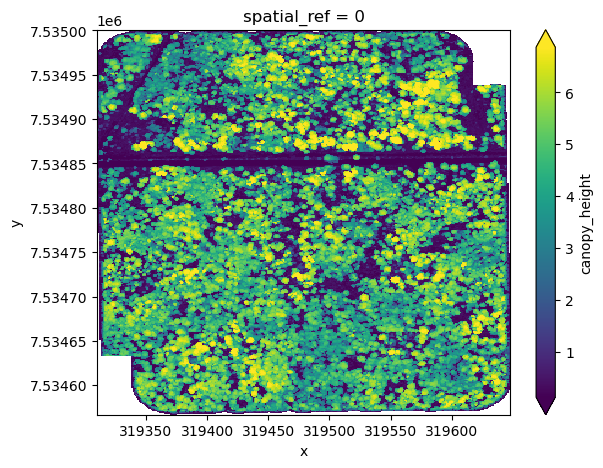

In [4]:
ds.plot.imshow(robust=True, size=5);

In [7]:
# ds.odc.explore(
#     tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#     attr = 'Esri',
#     name = 'Esri Satellite',
#     vmin=0, vmax=7
# )

In [10]:
# ds.odc.geobox

## Load Sentinel-2